# mag_calc additions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from diffpy.mpdf import *
from diffpy.structure import loadStructure
from scipy import constants as const
from time import time
import seaborn as sns
from __future__ import division
from mag_calc import MagCalc

%matplotlib inline

#### Make atoms and spins and create an instance of MagCalc.

In [2]:
structure = loadStructure('MnO_cubic.cif')
mspec = MagSpecies()

mspec.struc = structure

mspec.magIdxs = [0,1,2,3]
mspec.rmaxAtoms = 30

k = np.array([0.5,0.5,0.5])
s = np.array([1.0,-1.0,0.0])

mspec.kvecs = np.array([k])
mspec.basisvecs = np.array([s])
mstruc = MagStructure()
mstruc.loadSpecies(mspec)
mstruc.makeAtoms()
mstruc.makeSpins()
calc = MagCalc(atoms=mstruc.atoms, spins=mstruc.spins, g_factor=2, spin=.5, magneton='mu_B')

In [6]:
np.save('MnO_atoms', mstruc.atoms)
np.save('MnO_spins', mstruc.spins)

# Time optimizations

#### Make a random location to calculate the field at.

In [9]:
location = np.random.rand(3)

#### Time how long calculate_field takes without a mask.

In [12]:
start = time()
calc.calculate_field(location=location, return_vector=False)
time() - start

0.006175994873046875

#### Time how long it takes to make a mask and run calculate_field with that mask.

In [13]:
start = time()
mask = np.apply_along_axis(np.linalg.norm,
                           1,
                           location - mstruc.atoms) <= 8
calc.calculate_field(location=location, return_vector=False, mask=mask)
time() - start

0.11033511161804199

#### Clearly calculating the field without the mask is the faster option. Now lets look at calculate_fields.

In [29]:
with_mask = []
without_mask = []
x = range(1,60)

for i in x:
    locations = np.random.rand(i,3)
    
    start = time()
    calc.calculate_fields(locations=locations, mask_radius=None)
    without_mask.append(time() - start)
    
    start = time()
    calc.calculate_fields(locations=locations, mask_radius=8)
    with_mask.append(time() - start)

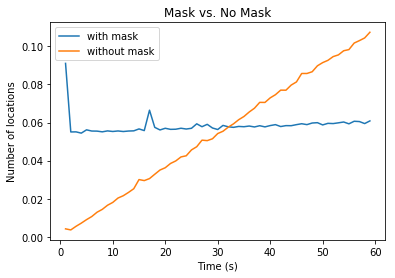

In [77]:
plt.plot(x, with_mask, label='with mask')
plt.plot(x, without_mask, label='without mask')
plt.xlabel('Time (s)')
plt.ylabel('Number of locations')
plt.title('Mask vs. No Mask')
plt.legend()
plt.show()

In [31]:
print([i for i, (a,b) in enumerate(zip(with_mask, without_mask)) if a < b][0])

32


#### So we see if len(locations) > ~30, calc_fields runs faster with a mask.

# make_grid

#### A useful applications of speeding up calculate_fields is a quicker way to visualize magnetic fields in the crystal. This can be done easily with make_grid

In [70]:
start = time()
fields = calc.make_grid(center_point=location, 
                        mask_radius=8, 
                        norm_axis='x', 
                        resolution=40, 
                        side_length=8, 
                        return_vector=False)
time() - start

19.994760990142822

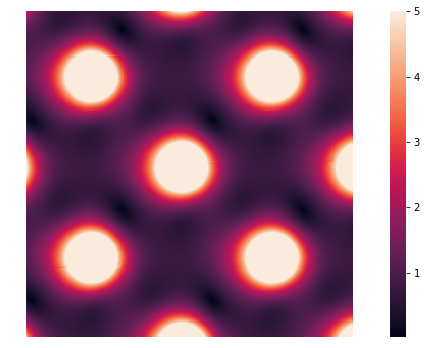

In [74]:
sns.heatmap(fields, vmax=5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.gcf().set_size_inches(8,6)
plt.show()

In [52]:
start = time()
fields = calc.make_grid(center_point=location, 
                        mask_radius=None, 
                        norm_axis='x', 
                        resolution=40, 
                        side_length=8, 
                        return_vector=False)
time() - start

208.27226901054382

# find_field

#### Create an array of fields we want to find locations for.

In [61]:
fields = np.arange(0.1, 1, 0.1)
fields

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

#### Find locations for each of those fields.

In [62]:
locations = np.array([calc.find_field(field=field) for field in fields])
locations

array([[ 7.8629    , -1.09462249,  4.91093928],
       [16.24637434,  7.40583168,  3.3103215 ],
       [ 4.42090271,  8.75983845,  7.07111525],
       [ 9.80836762,  1.26581139, 12.74585121],
       [ 7.9255248 , 14.58709666, -2.73155899],
       [ 2.63366413, 15.66854223,  1.99208875],
       [ 2.97780773,  2.61478517,  7.49127651],
       [ 8.45777432, 14.63589701,  7.81169343],
       [ 5.44727556,  0.94382271,  7.58975773]])

#### Double check that the locations we calculated give us the fields we were looking for.

In [67]:
out_fields = calc.calculate_fields(locations=locations, return_vector=False)
out_fields

array([0.10000002, 0.19999988, 0.29999996, 0.39999995, 0.50000007,
       0.59999999, 0.69999996, 0.79999987, 0.90000006])

In [68]:
np.allclose(fields, out_fields)

True